## CX4240 project

# Classification of Acute Lymphoblastic Leukemia (ALL) in Blood Cell Images Using Machine Learning





In [21]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import mahotas as mt
import pywt
import seaborn as sns
import pandas as pd
from skimage.feature import local_binary_pattern
%matplotlib inline


# Load Images

In [2]:
def find_path(stage, fold=None, label=None):
    """
    ARGS:    stage: 'train' or 'test'
             fold: int
             label: 'all' or 'hem'
    returns: general file path for given inputs
    """
    og_path = '/Users/1000j/CX4240+/Cell_Images/'
    if stage == 'train':
        return og_path + 'C-NMC_training_data/fold_' + str(fold) + '/' + label + '/*.bmp'
    elif stage == 'test':
        return og_path + 'C-NMC_test_prelim_phase_data/'*2 + '*.bmp'
    else:
        print('must enter "train" or "test"')
        return

def read_images(stage, fold=None, label=None):
    """
    ARGS:    stage: 'train' or 'test'
             fold: int
             label: 'all' or 'hem'
    returns: color: list of all color images
             gray: list of all gray images
             ids: list of associated image ids
    """
    
    img_path = find_path(stage, fold, label)
    start = len(img_path) - 5
#    color, gray, ids = [], [], []
    
    ids = []
    for name in glob.glob(img_path):
        ids.append(name[start : -4])
#        color.append(cv2.imread(name))
#        gray.append(cv2.imread(name, 0))
    color = np.array([cv2.imread(file) for file in glob.glob(img_path)])
    gray = np.array([cv2.imread(file,0) for file in glob.glob(img_path)])
    ret, binary = cv2.threshold(gray,20,255,cv2.THRESH_BINARY)

    print('done loading images')
    return color, gray, binary, ids

In [3]:
ALL_0_color, ALL_0_gray, ALL_0_binary, ids_0_ALL = read_images('train', 0, 'all')
hem_0_color, hem_0_gray, hem_0_binary, ids_0_hem = read_images('train', 0, 'hem')

done loading images
done loading images


(<matplotlib.axes._subplots.AxesSubplot at 0x1bcb7824128>,
 Text(0.5, 1.0, 'Normal binary'))

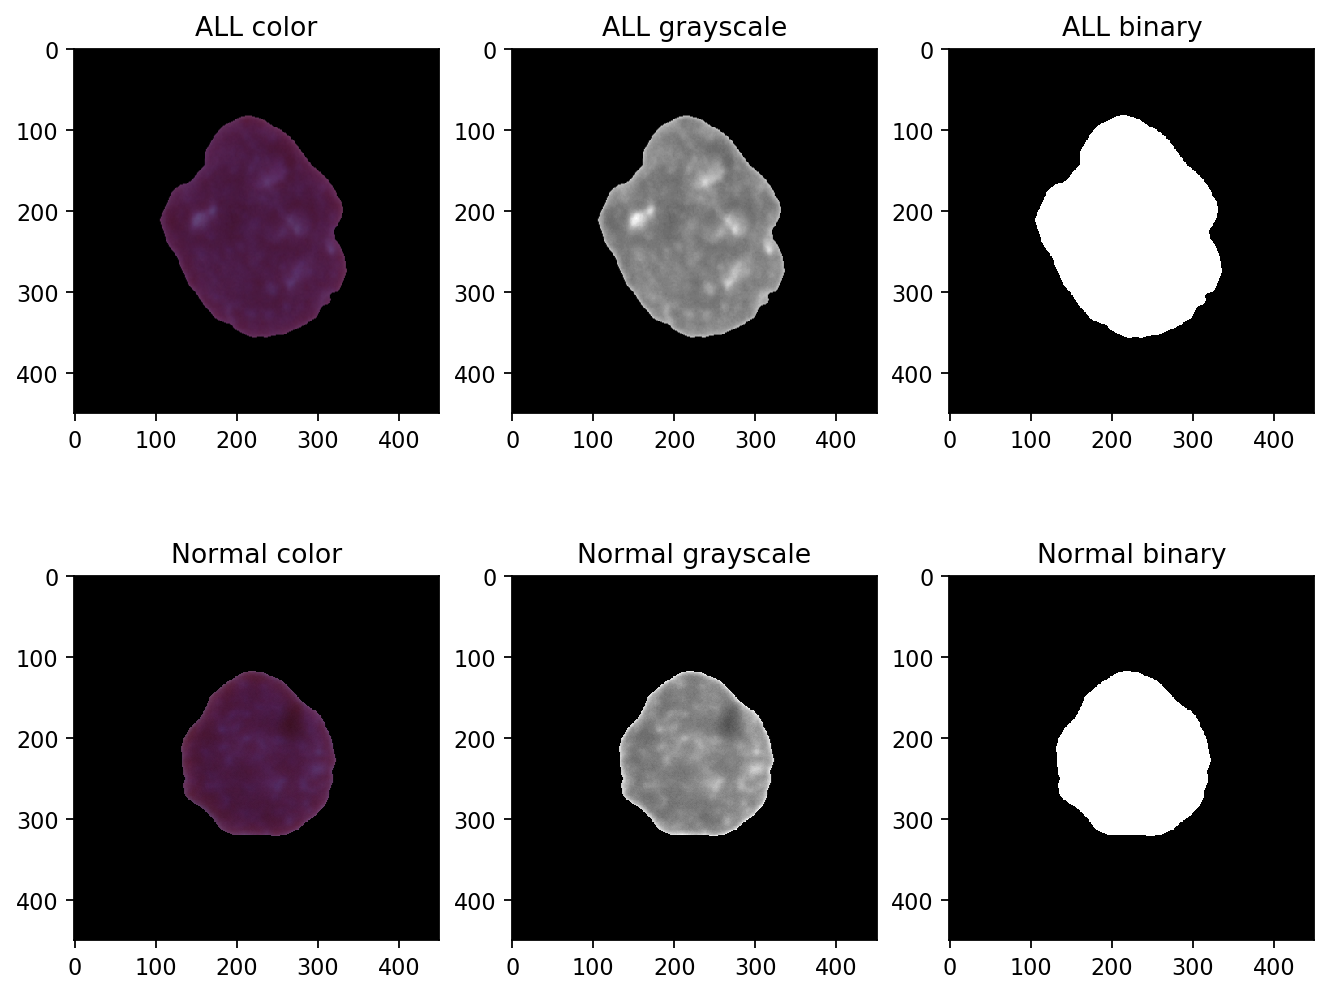

In [5]:
plt.figure(num=None, figsize=(10, 8), dpi=160, facecolor='w', edgecolor='k')
plt.subplot(2,3,1), plt.imshow(ALL_0_color[1270]), plt.title('ALL color')
plt.subplot(2,3,2), plt.imshow(ALL_0_gray[1270],'gray'), plt.title('ALL grayscale')
plt.subplot(2,3,3), plt.imshow(ALL_0_binary[1270],'gray'), plt.title('ALL binary')
plt.subplot(2,3,4), plt.imshow(hem_0_color[127]), plt.title('Normal color')
plt.subplot(2,3,5), plt.imshow(hem_0_gray[127],'gray'), plt.title('Normal grayscale')
plt.subplot(2,3,6), plt.imshow(hem_0_binary[127],'gray'), plt.title('Normal binary')

# Feature extraction
    F1: cell size
    F2: perimeter
    F3: form factor
    F4: roundness
    F5: length/diameter ratio
    F6: compactness
    F7: cell boundary roughness
    F8-F10: contour signature of nucleus: 
        variance, skewness, and kurtosis of the distances between centroid and contour points
    F11-F23: Haralick texture 
        angular second moment
        contrast
        correlation
        variance
        inverse difference moment
        sum average
        sum variance
        sum entropy
        difference entropy
        information measures of correlation (F12, F13)
    F24-31: Haar wavelet texture
        Means and variances of low-pass filtered appriximation image 
        and high-pass filterd in horizontal, vertical, and diagonal directions
    F32-F..: color features

## Morphological feature extraction

In [29]:
#Morphological features
def get_cell_size(image):
    """
    ARGS:    
        image: black and white image
    returns:
        size: the number of pixels in the cell
    """
    
#    ret,thresh=cv2.threshold(image,THRESH,255,cv2.THRESH_BINARY)
#    return cv2.countNonZero(image)
    return np.count_nonzero(image, axis=(1,2))

def get_cell_perimeter(image):
    """
    ARGS:    
        image: black and white image
    returns:
        perimeter: the number of pixels in the perimeter
        cnt: x,y coordiantes of boundary (list)
    """
#    ret,thresh = cv2.threshold(image,THRESH,255,cv2.THRESH_BINARY)
    perimeter = np.zeros(len(image))
    cnt = []
    for i in range(len(image)):
        _, contour, _ = cv2.findContours(image[i], cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        perimeter[i] = contour[0].shape[0]
        cnt.append(contour[0])
    return perimeter, cnt

def get_centeroid(image):
    """
    arg:
        image: binary image
    returns:
        cx: x coordinate of center
        cy: y coordinate of center
    """
    cx = np.zeros(len(image), dtype=int)
    cy = np.zeros(len(image), dtype=int)
    for i in range(len(image)):
        M = cv2.moments(image[i])
        cx[i] = int(M['m10']/M['m00'])
        cy[i] = int(M['m01']/M['m00'])
    return cx,cy

def get_diameter(image):
    """
    args:
        image: binary images
    returns: 
        major_d: maximum diameter (number of pixels) on the major axis
        minor_d: diameter (number of pixels) on the minor axis (perpendicular to the major axis)
        min_d: minimum diameter 
    """
    (rows, cols) = image[0].shape[:2] 
    major_d = np.zeros(len(image))
    minor_d = np.zeros(len(image))
    min_d = rows*np.ones(len(image))
    major_img = np.zeros(np.shape(image))
    minor_img = np.zeros(np.shape(image))
    for i in range(len(image)):
        for ang in range(0,180,10):
            # Images are rotated 0 to 170 degrees with the increment of 10 degrees
            # getRotationMatrix2D creates a matrix needed for transformation. 
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), ang, 1) 
            rotated_img = cv2.warpAffine(image[i], M, (cols, rows))
            temp_d = np.count_nonzero(rotated_img[int(rows/2),:]) # count pixels
            if temp_d > major_d[i]:
                major_d[i] = temp_d
                minor_d[i] = np.count_nonzero(rotated_img[:,int(cols/2)]) 
            if temp_d < min_d[i]:
                min_d[i] = temp_d
    return major_d, minor_d, min_d



In [30]:
#F1 size
F1_all = get_cell_size(ALL_0_binary)
F1_hem = get_cell_size(hem_0_binary)
#F2 perimeter
F2_all, cnt_all = get_cell_perimeter(ALL_0_binary)
F2_hem, cnt_hem = get_cell_perimeter(hem_0_binary)

ALL_0_major_d, ALL_0_minor_d, ALL_0_min_d = get_diameter(ALL_0_binary)
hem_0_major_d, hem_0_minor_d, hem_0_min_d= get_diameter(hem_0_binary)
ALL_0_cx, ALL_0_cy = get_centeroid(ALL_0_binary)
hem_0_cx, hem_0_cy = get_centeroid(hem_0_binary)

In [8]:
def get_form_factor(area, perimeter):
    """
    args: 
        area: area of cell
        perimeter: the total number of pixels representing the cell boundary
    returns: 
        form_factor: shape of cell
    """
    return 4*np.pi*area/perimeter**2

def get_roundness(area, major_diameter):
    """
    args: 
        area: area of cell
        major_diameter: diameter of cell on the major axis
    returns: roundness
    """
    return 4*area/(np.pi*major_diameter**2)

def get_diameter_ratio(major_d, minor_d):
    """
    args:
        major_d: maximum diameter (number of pixels) on the major axis
        minor_d: diameter (number of pixels) on the minor axis (perpendicular to the major axis
    returns: 
        ratio: ratio of major_d and minor_d
    """
    return major_d/minor_d

def get_compactness(area, major_diameter):
    """
    args: 
        area: area of cell
        major_diameter: diameter of cell on the major axis
    returns: compactness
        
    """
    return ((4*area/np.pi)**(-1/2))/major_diameter

In [12]:
#F3 form factor
F3_all = get_form_factor(F1_all, F2_all)
F3_hem = get_form_factor(F1_hem, F2_hem)
#F4 roundness
F4_all = get_roundness(F1_all, ALL_0_major_d)
F4_hem = get_roundness(F1_hem, hem_0_major_d)
#F5 diameter ratio
F5_all = get_diameter_ratio(ALL_0_major_d, ALL_0_minor_d)
F5_hem = get_diameter_ratio(hem_0_major_d, hem_0_minor_d)
#F6 compactness
F6_all = get_compactness(F1_all, ALL_0_major_d)
F6_hem = get_compactness(F1_hem, hem_0_major_d)

## Texture features extraction

In [13]:
# Texture features
def crop_image(image, cx, cy, min_d=50):
    """
        args:
            image: grayscale image
            cx: x coordinate of center (row)
            cy: y coordiante of center (column)
            mid_d: (int) minimum diameter of all cells
        returns:
            new_img: cropped images with size min_d by min_d
    """
    rows, cols = image[0].shape[:2] 
    l = np.int(np.min(min_d)/2)
    for i in range(len(image)):
        new_img = image[:,cx[i]-l:cx[i]+l,cy[i]-l:cy[i]+l]
    return new_img

def Haralick(img):
    '''Haralick texture using Gray-level co-occurrence matrix (GLCM)
    arg: 
        img: N number of MxM grayscale images
    return: 
        Haralick_texture: Nx13 array with 13 features 
    '''
    Haralick_texture = []
    for i in range(len(img)):
        feat = mt.features.haralick(img[i,:,:], return_mean=True)
        Haralick_texture.append(feat)
    Haralick_texture = np.array(Haralick_texture)     
    return Haralick_texture
    
def Haar_wavelet(img):
    '''Extract Haar wavelet texture features
    Means and variances of low-pass filtered appriximation image 
    and high-pass filterd in horizontal, vertical, and diagonal directions
    arg:
        img: N number of MxM grayscale images
    return: 
        Haar_wavelet_features: Nx8 array with 8 features
            (cA_mean, cH_mean, cV_mean, cD_mean, cA_var, cH_var, cV_var, and cD_var)
    '''
    cA, (cH, cV, cD) = pywt.dwt2(img,'haar')
    n = len(cA)
    cA_mean = np.reshape(cA.mean(axis=(1,2)), (n,1))
    cH_mean = np.reshape(cH.mean(axis=(1,2)), (n,1))
    cV_mean = np.reshape(cV.mean(axis=(1,2)), (n,1))
    cD_mean = np.reshape(cD.mean(axis=(1,2)), (n,1))
    cA_var = np.reshape(cA.var(axis=(1,2)), (n,1))
    cH_var = np.reshape(cH.var(axis=(1,2)), (n,1))
    cV_var = np.reshape(cV.var(axis=(1,2)), (n,1))
    cD_var = np.reshape(cD.var(axis=(1,2)), (n,1))
    
    Haar_wavelet_features = np.hstack((cA_mean,cH_mean,cV_mean,cD_mean,cA_var,cH_var,cV_var,cD_var))
    return Haar_wavelet_features

# Local Binary Patterns
# lbp = feature.local_binary_pattern(all0_gray, , radius, method="uniform")


In [18]:
#new images for texture feature extraction
ALL_0_texture = crop_image(ALL_0_gray, ALL_0_cx, ALL_0_cy)
hem_0_texture = crop_image(hem_0_gray, hem_0_cx, hem_0_cy)

#F11-F23
Haralick_all = Haralick(ALL_0_texture)
Haralick_hem = Haralick(hem_0_texture)
#F24-31
Haar_wavelet_all = Haar_wavelet(ALL_0_texture)
Haar_wavelet_hem = Haar_wavelet(hem_0_texture)    

## Color feature extraction

In [ ]:
# color features


In [19]:
# combine all features
ALL = np.stack((F1_all,F2_all,F3_all,F4_all,F5_all,F6_all), axis=1)
hem = np.stack((F1_hem,F2_hem,F3_hem,F4_hem,F5_hem,F6_hem), axis=1)
ALL = np.concatenate((ALL,Haralick_all,Haar_wavelet_all), axis=1)
hem = np.concatenate((hem,Haralick_hem,Haar_wavelet_hem), axis=1)
print('Shape of ALL:', np.shape(ALL))
print('Shape of hem:', np.shape(hem))

Shape of ALL: (2397, 27)
Shape of hem: (1130, 27)


In [ ]:
# Feature normalizstion


# Dimension reduction


In [ ]:
# PCA


C:\Users\1000j\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


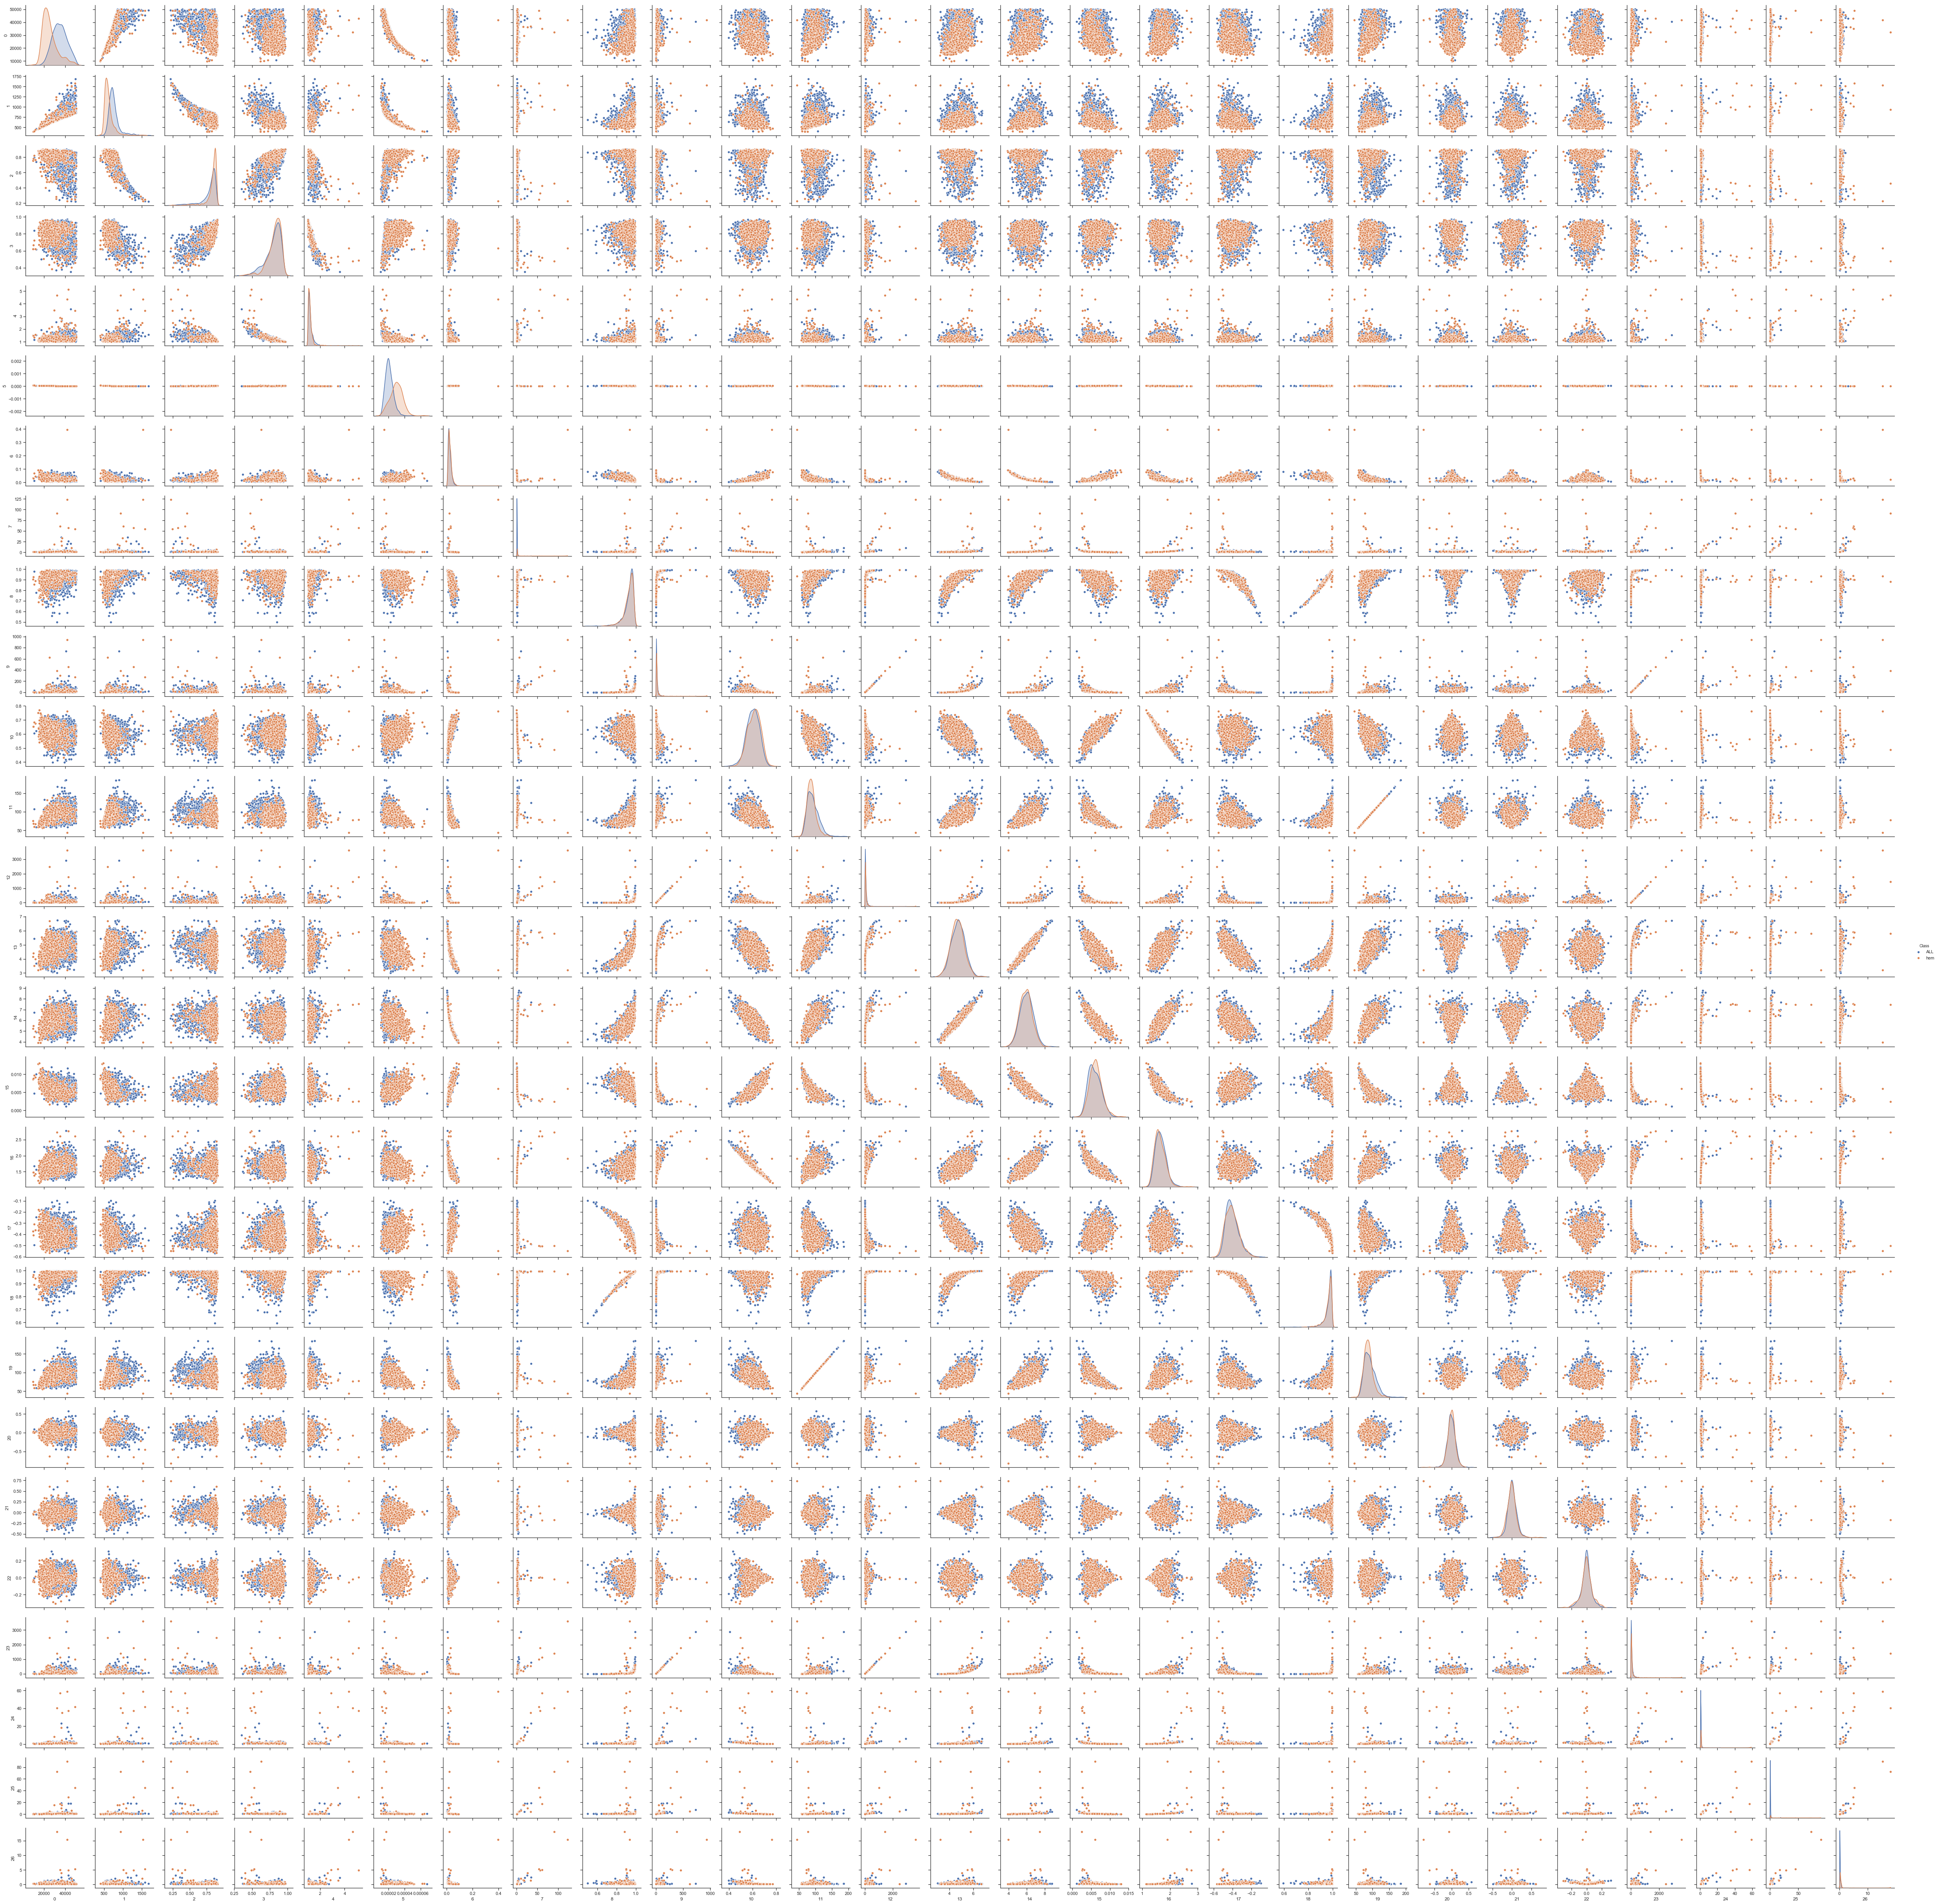

In [27]:
# Feature visualization
data = np.concatenate((ALL,hem), axis=0)
data_df = pd.DataFrame.from_records(data)
Class = np.concatenate((['ALL']*len(ALL),['hem']*len(hem)), axis=0)
data_df.insert(0,"Class",Class,True)
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(data_df, hue="Class")

# Classification

## Support Vector Machine (SVM)

In [ ]:
#SVM
